<a href="https://colab.research.google.com/github/AritraStark/CSC507-W7/blob/master/W7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Week 7 Assignment: Synthetic Data for Fraud Detection**

Setting up imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns

Task 1: Generate a Synthetic Imbalanced Dataset

In [2]:
X, y = make_classification(
    n_samples=500_000,
    n_features=50,
    n_informative=25,
    n_redundant=10,
    n_clusters_per_class=4,
    weights=[0.9, 0.1],
    random_state=7
)

In [3]:
print("Dataset Details:")
print(f"Shape of features (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}\n")

# Verify the class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution in the original dataset:")
print(f"Class {unique[0]} (Negative): {counts[0]} samples")
print(f"Class {unique[1]} (Positive): {counts[1]} samples")

Dataset Details:
Shape of features (X): (500000, 50)
Shape of labels (y): (500000,)

Class distribution in the original dataset:
Class 0 (Negative): 447980 samples
Class 1 (Positive): 52020 samples


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7
)

In [15]:
print("After split: ")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}\n")

train_unique, train_counts = np.unique(y_train, return_counts=True)
print("Class distribution in the train set:")
print(f"Class {train_unique[0]} (Negative): {train_counts[0]} samples")
print(f"Class {train_unique[1]} (Positive): {train_counts[1]} samples\n")


test_unique, test_counts = np.unique(y_test, return_counts=True)
print("Class distribution in the test set:")
print(f"Class {test_unique[0]} (Negative): {test_counts[0]} samples")
print(f"Class {test_unique[1]} (Positive): {test_counts[1]} samples")


After split: 
Shape of X_train: (400000, 50)
Shape of X_test: (100000, 50)

Class distribution in the train set:
Class 0 (Negative): 358384 samples
Class 1 (Positive): 41616 samples

Class distribution in the test set:
Class 0 (Negative): 89596 samples
Class 1 (Positive): 10404 samples


Task 2: Balance the Training Data with SMOTE

In [6]:
print("Before SMOTE: ")
unique_before, counts_before = np.unique(y_train, return_counts=True)
print(f"Original training set shape: {X_train.shape}")
print("Class distribution in the original train set:")
print(f"Class {unique_before[0]} (Negative): {counts_before[0]} samples")
print(f"Class {unique_before[1]} (Positive): {counts_before[1]} samples")


Before SMOTE: 
Original training set shape: (400000, 50)
Class distribution in the original train set:
Class 0 (Negative): 358384 samples
Class 1 (Positive): 41616 samples


In [7]:
smote = SMOTE(random_state=7)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [16]:
print("After SMOTE: ")
unique_after, counts_after = np.unique(y_train_smote, return_counts=True)
print(f"Resampled training set shape: {X_train_smote.shape}")
print("Class distribution in the SMOTE train set:")
print(f"Class {unique_after[0]} (Negative): {counts_after[0]} samples")
print(f"Class {unique_after[1]} (Positive): {counts_after[1]} samples")

After SMOTE: 
Resampled training set shape: (716768, 50)
Class distribution in the SMOTE train set:
Class 0 (Negative): 358384 samples
Class 1 (Positive): 358384 samples


Task 3: Model Training and Evaluation


In [9]:
model_imbalanced = LogisticRegression(max_iter=5000, solver="lbfgs")
model_imbalanced.fit(X_train, y_train)
y_pred_imbalanced = model_imbalanced.predict(X_test)

model_balanced = LogisticRegression(max_iter=5000, solver="lbfgs")
model_balanced.fit(X_train_smote, y_train_smote)
y_pred_balanced = model_balanced.predict(X_test)

Classification Reports:

In [10]:
def get_classification_report(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=["Majority", "Minority"])
    df_report = pd.DataFrame(report_dict).transpose()
    df_report = df_report.round(3)
    return df_report.iloc[0:2, 0:3]

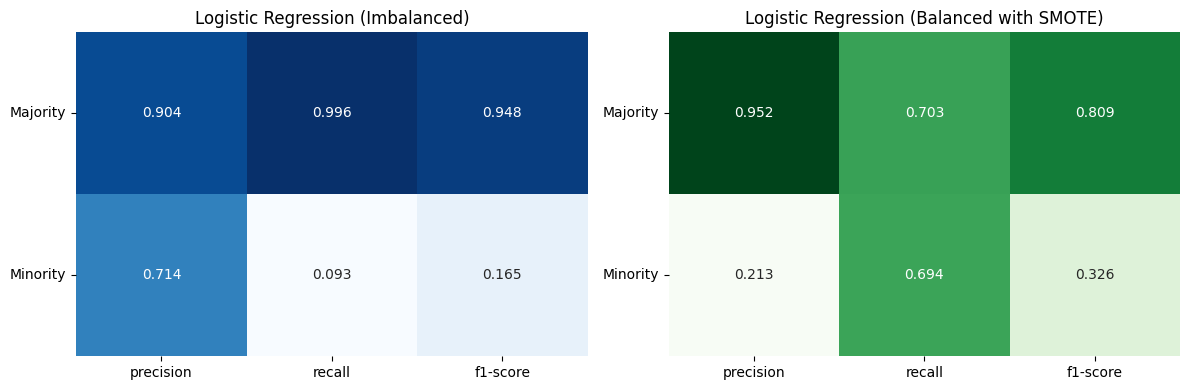

In [11]:
df_imbalanced = get_classification_report(y_test, y_pred_imbalanced)
df_balanced = get_classification_report(y_test, y_pred_balanced)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(df_imbalanced, annot=True, cmap="Blues", cbar=False, fmt=".3f", ax=axes[0])
axes[0].set_title("Logistic Regression (Imbalanced)")
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

sns.heatmap(df_balanced, annot=True, cmap="Greens", cbar=False, fmt=".3f", ax=axes[1])
axes[1].set_title("Logistic Regression (Balanced with SMOTE)")
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

ROC Curves:

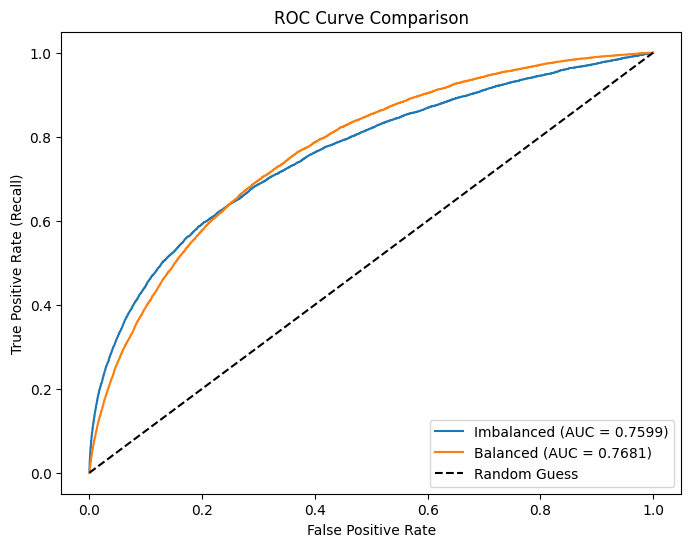

In [12]:
y_proba_imbalanced = model_imbalanced.predict_proba(X_test)[:, 1]
y_proba_balanced = model_balanced.predict_proba(X_test)[:, 1]

fpr1, tpr1, _ = roc_curve(y_test, y_proba_imbalanced)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_proba_balanced)
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, label=f"Imbalanced (AUC = {roc_auc1:.4f})")
plt.plot(fpr2, tpr2, label=f"Balanced (AUC = {roc_auc2:.4f})")
plt.plot([0,1], [0,1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


Precision-Recall Curves:

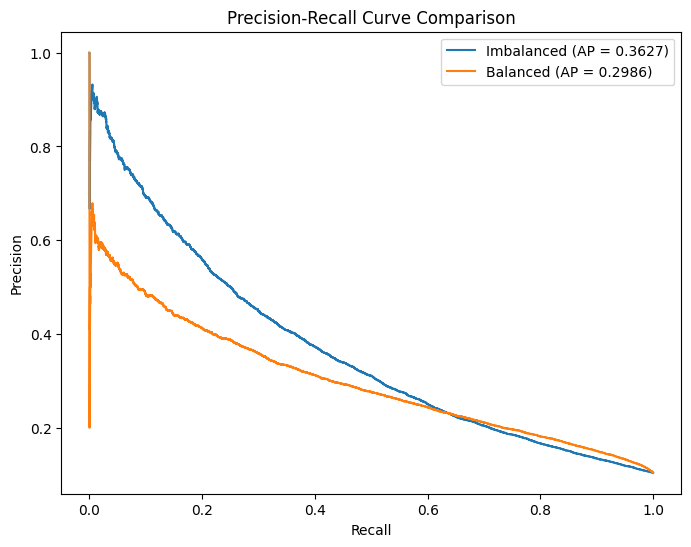

In [13]:
precision1, recall1, _ = precision_recall_curve(y_test, y_proba_imbalanced)
ap1 = average_precision_score(y_test, y_proba_imbalanced)

precision2, recall2, _ = precision_recall_curve(y_test, y_proba_balanced)
ap2 = average_precision_score(y_test, y_proba_balanced)

plt.figure(figsize=(8,6))
plt.plot(recall1, precision1, label=f"Imbalanced (AP = {ap1:.4f})")
plt.plot(recall2, precision2, label=f"Balanced (AP = {ap2:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="upper right")
plt.show()

Confusion Matrices:

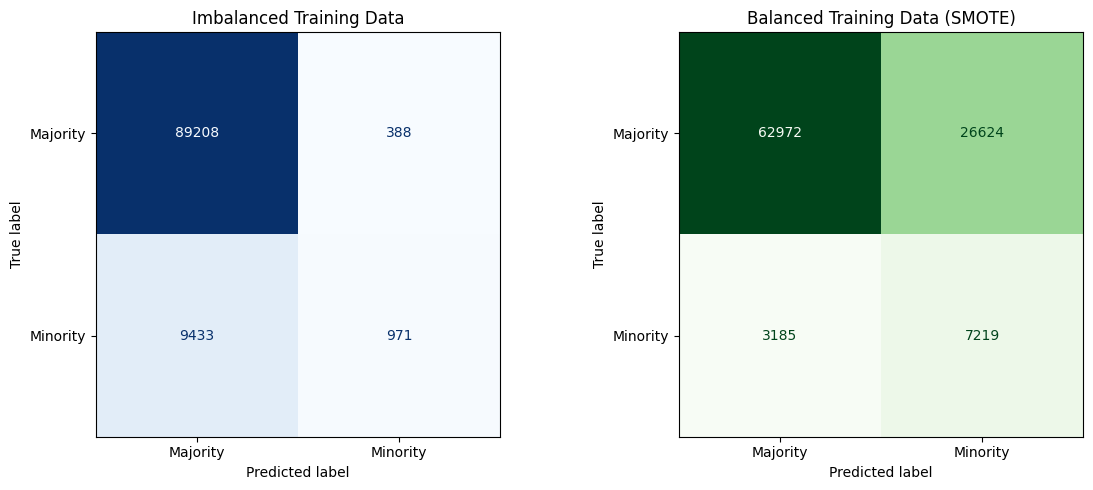

In [14]:
cm_imbalanced = confusion_matrix(y_test, y_pred_imbalanced)
cm_balanced = confusion_matrix(y_test, y_pred_balanced)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_imbalanced, display_labels=["Majority", "Minority"])
disp1.plot(ax=axes[0], values_format="d", cmap="Blues", colorbar=False)
axes[0].set_title("Imbalanced Training Data")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=["Majority", "Minority"])
disp2.plot(ax=axes[1], values_format="d", cmap="Greens", colorbar=False)
axes[1].set_title("Balanced Training Data (SMOTE)")

plt.tight_layout()
plt.show()